# 1. "A quantidade de pedido mensal segue um padrão sazonal"

In [1]:
from scipy import stats

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
orders = pd.read_csv("../datasets/trusted/delivered_orders.csv")
orders.count()

Unnamed: 0                       93011
order_id                         93011
customer_id                      93011
order_approved_at                92997
order_purchase_timestamp         93011
order_estimated_delivery_date    93011
order_delivered_carrier_date     93009
order_delivered_customer_date    93003
dtype: int64

In [51]:
purchase_time = pd.to_datetime(orders['order_purchase_timestamp'])

orders_by_year_and_month = pd.DataFrame({
        'id': orders['order_id'],
        'year': purchase_time.dt.year,
        'month': purchase_time.dt.month,
        'day': purchase_time.dt.day,
})

count_by_month = orders_by_year_and_month.groupby(['year', 'month', 'day']).agg(['count'])

count_by_month['id'] = np.fft.fft(count_by_month['id'], axis=0)
count_by_month = count_by_month.reset_index().groupby(['year', 'month'])
months = count_by_month.groups
len(months.keys())

20

In [52]:
populations = [count_by_month.get_group(m)['id'].iloc[:, 0].values for m in months]

print(stats.kruskal(*populations).pvalue * 100, "%", sep='')

55.13510766856656%


0.1745118699528908%


/home/guilherme.brandt/.local/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


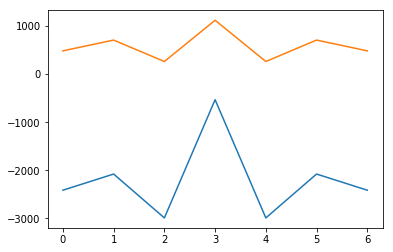

In [53]:
count_by_year = orders_by_year_and_month.groupby(['year', 'month']).agg(['count'])

fourier_2017 = np.fft.fft(count_by_year['id'][:8], axis=0)[1:]
fourier_2018 = np.fft.fft(count_by_year['id'][12:], axis=0)[1:]

plt.plot(fourier_2017)
plt.plot(fourier_2018)
print(stats.kruskal(fourier_2017, fourier_2018).pvalue * 100, "%", sep='')